In [14]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

spotify_df = pd.read_csv(Path("../Resources/spotify-2023_updated.csv"))
spotify_df.head()

,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_charts,streams,in_apple_charts,bpm,mode,danceability_pct,valence_pct,energy_pct,acousticness_pct,instrumentalness_pct,liveness_pct,speechiness_pct
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,147,141381703,263,125,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,48,133716286,126,92,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,113,140003974,207,138,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,100,800840817,207,170,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,50,303236322,133,144,Minor,65,23,80,14,63,11,6


In [2]:
spotify_df = spotify_df.drop(["track_name", "artist_name", "in_spotify_charts", "in_apple_charts",], axis=1)

In [3]:
bins = [0, 1000000000, 2000000000, float("inf")] 

# 0 = low, 1 = medium, 3 = high
labels = [0, 1, 2]

spotify_df["stream_category"] = pd.cut(spotify_df["streams"], bins=bins, labels=labels)
spotify_df["stream_category"] = spotify_df["stream_category"].astype(int)
spotify_df["stream_category"].value_counts()



stream_category
0    801
1    121
2     31
Name: count, dtype: int64

In [4]:
spotify_df = spotify_df.drop("streams", axis = 1)

In [5]:
df = spotify_df.drop("mode", axis = 1)

dummies_df = pd.get_dummies(spotify_df["mode"], dtype=int)

final_df = pd.concat([df, dummies_df], axis=1)
final_df.head()

,artist_count,released_year,released_month,released_day,bpm,danceability_pct,valence_pct,energy_pct,acousticness_pct,instrumentalness_pct,liveness_pct,speechiness_pct,stream_category,Major,Minor
0,2,2023,7,14,125,80,89,83,31,0,8,4,0,1,0
1,1,2023,3,23,92,71,61,74,7,0,10,4,0,1,0
2,1,2023,6,30,138,51,32,53,17,0,31,6,0,1,0
3,1,2019,8,23,170,55,58,72,11,0,11,15,0,1,0
4,1,2023,5,18,144,65,23,80,14,63,11,6,0,0,1


In [6]:
# splitting our data into target and features

# defining features
X = final_df.drop("stream_category", axis=1)

# defining target
y = final_df["stream_category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [7]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [8]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)


In [9]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1", "Actual 2"], columns=["Predicted 0", "Predicted 1", "Predicted 2"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [10]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1,Predicted 2
Actual 0,180,17,4
Actual 1,18,10,2
Actual 2,1,4,3


Accuracy Score : 0.8075313807531381
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       201
           1       0.32      0.33      0.33        30
           2       0.33      0.38      0.35         8

    accuracy                           0.81       239
   macro avg       0.52      0.53      0.53       239
weighted avg       0.81      0.81      0.81       239



In [11]:
importances = model.feature_importances_

sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.3051591020612071, 'released_year'),
 (0.1225557513041381, 'bpm'),
 (0.11216393334515445, 'released_day'),
 (0.10514383680744244, 'valence_pct'),
 (0.10480541822399192, 'liveness_pct'),
 (0.08279974357372018, 'danceability_pct'),
 (0.06701509125141798, 'energy_pct'),
 (0.03905389898792878, 'released_month'),
 (0.02283866582587088, 'instrumentalness_pct'),
 (0.022427505294684656, 'acousticness_pct'),
 (0.01603705332444356, 'speechiness_pct'),
 (0.0, 'artist_count'),
 (0.0, 'Minor'),
 (0.0, 'Major')]

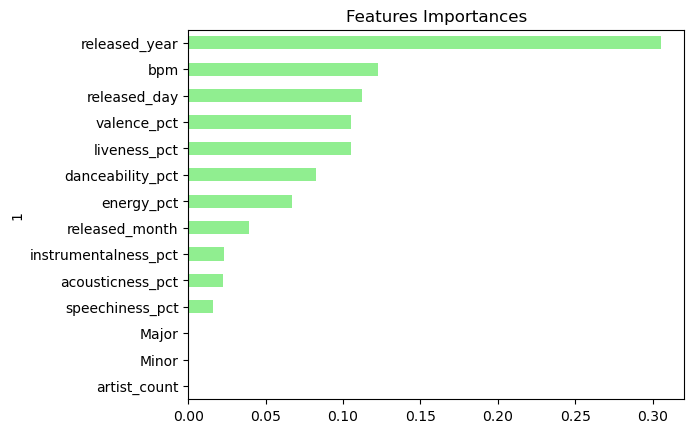

In [18]:
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

plt.savefig("../Images/Feature Importance/Decision Tree Model Feature Importance")
plt.show()